In [14]:
# 在pytorch中，batch_size和time_step两个参数都可以是动态的，这里用rnn regression模型，考虑time_step是动态的情况,注意39~43行
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

In [15]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step 
INPUT_SIZE = 1      # rnn input size ,某个时间点上的输入值只有y，因此是1
LR = 0.02           # learning rate
DOWNLOAD_MNIST = False  # set to True if haven't download the data

20


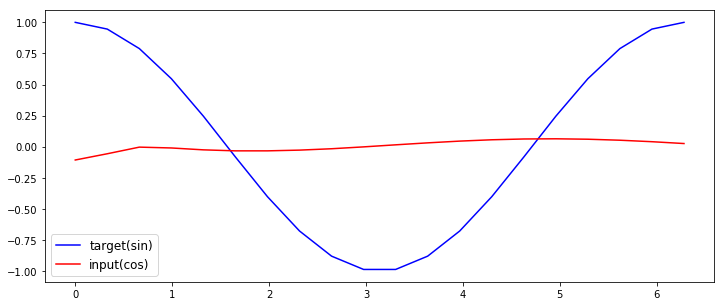

20


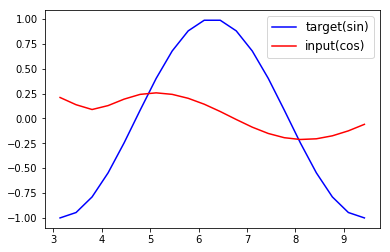

10


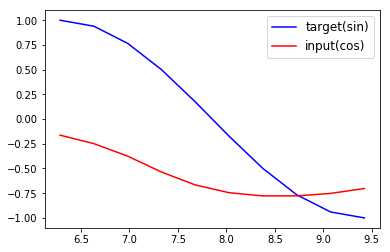

10


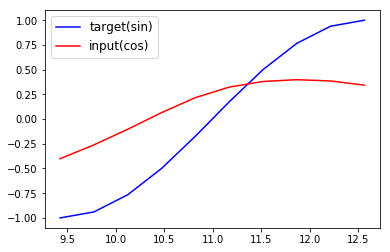

10


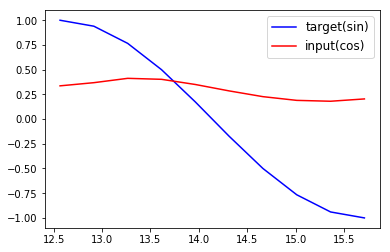

20


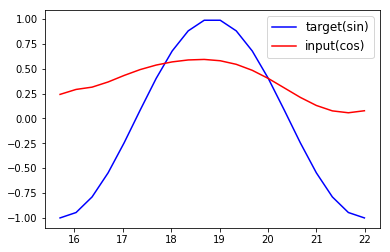

30


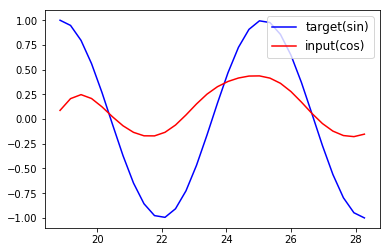

20


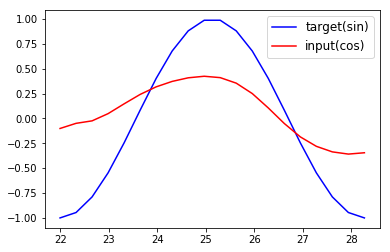

10


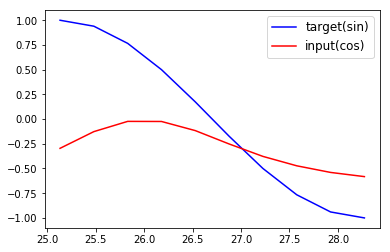

30


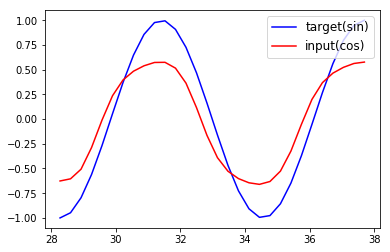

30


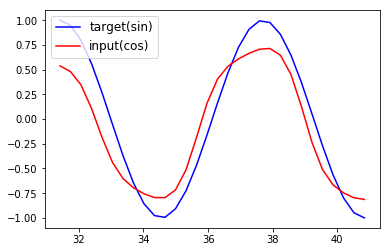

20


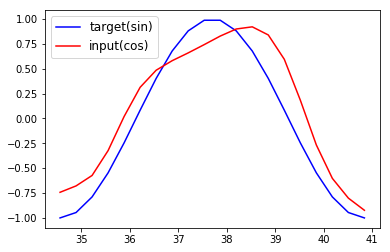

10


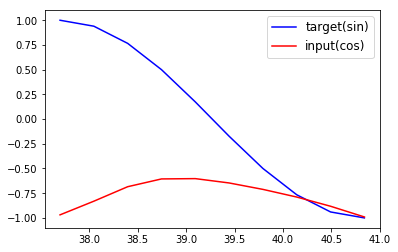

30


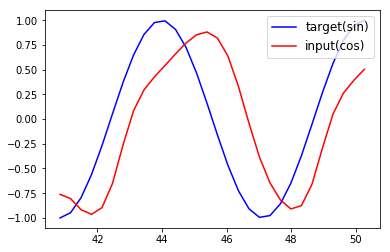

20


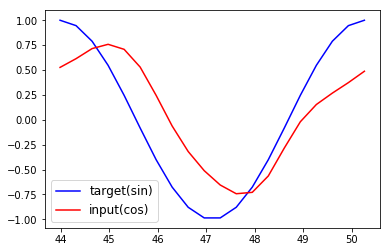

30


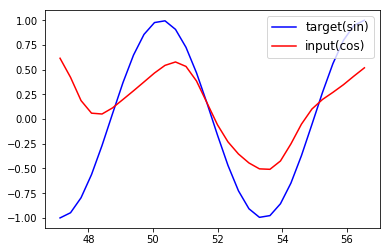

20


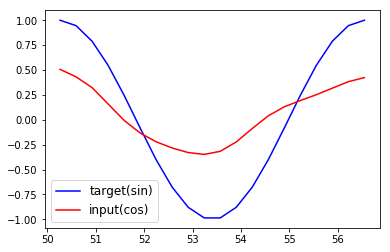

30


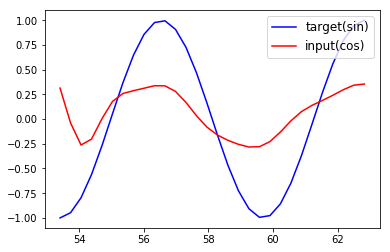

20


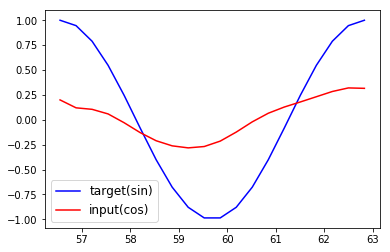

10


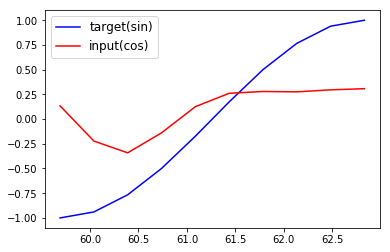

20


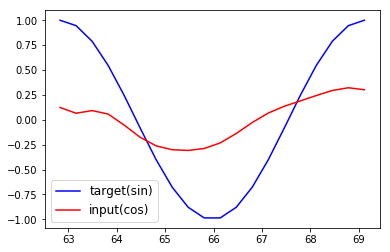

30


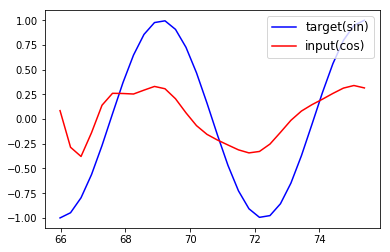

30


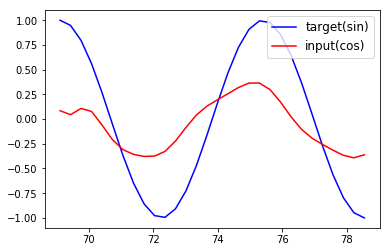

20


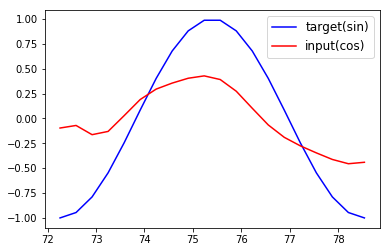

30


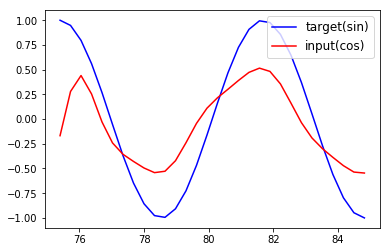

20


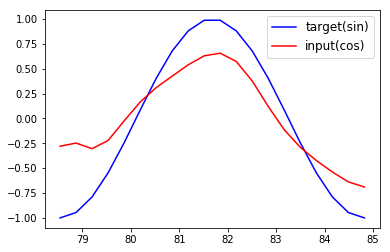

20


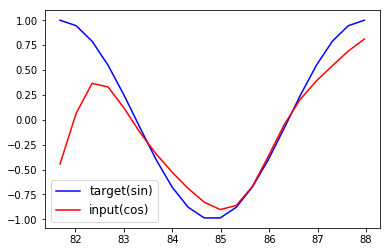

10


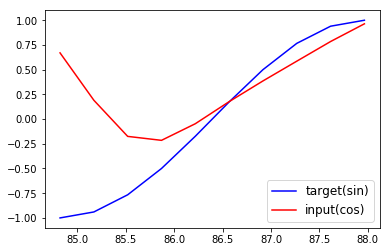

20


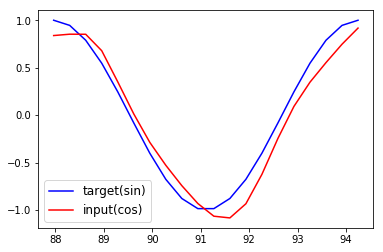

20


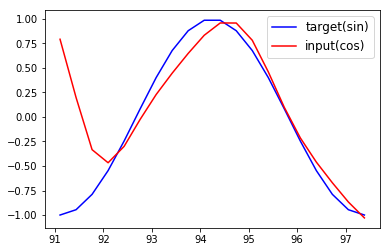

10


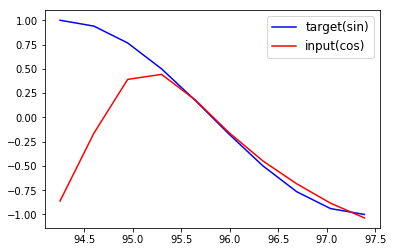

20


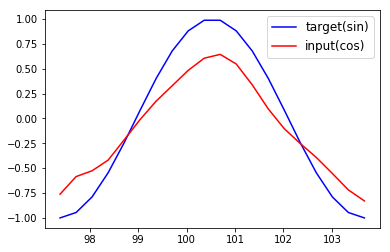

20


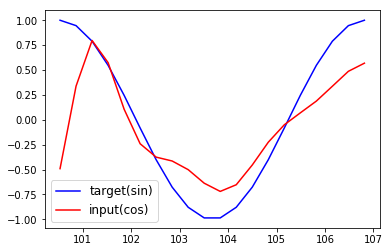

10


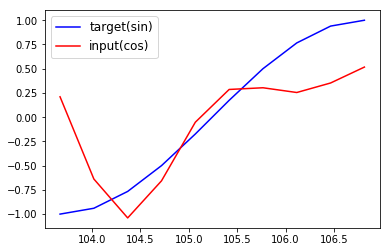

30


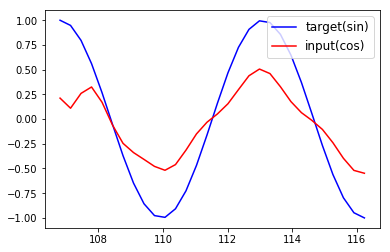

20


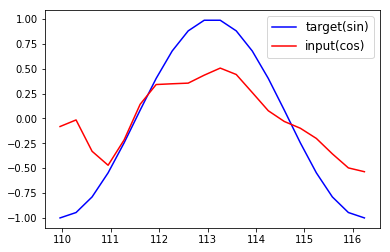

10


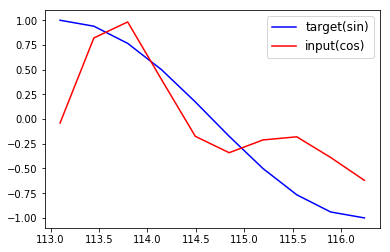

20


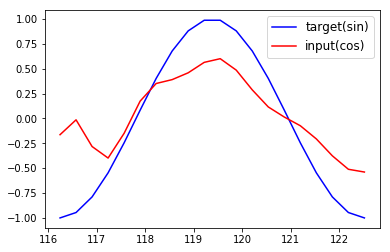

20


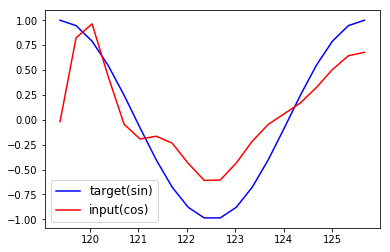

20


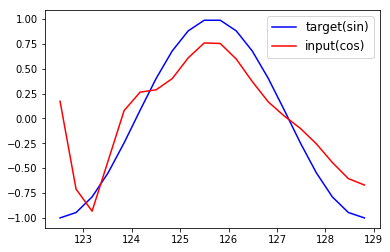

10


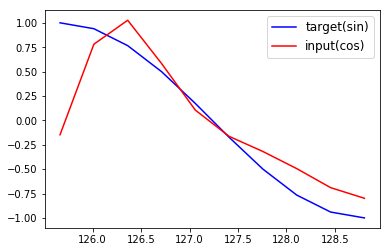

30


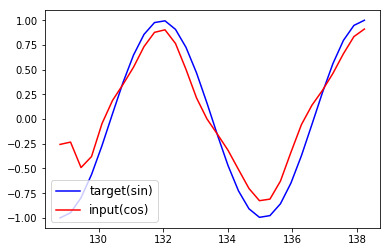

10


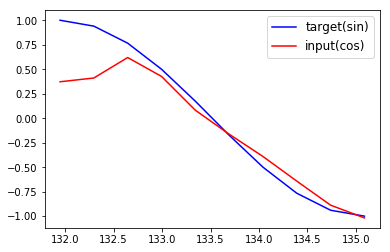

20


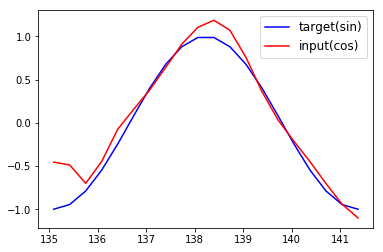

30


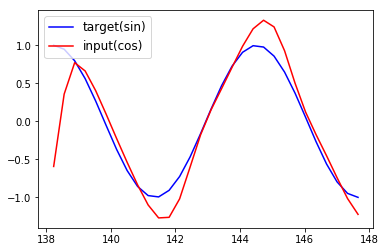

20


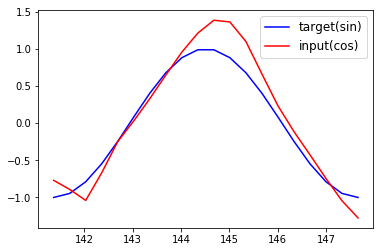

20


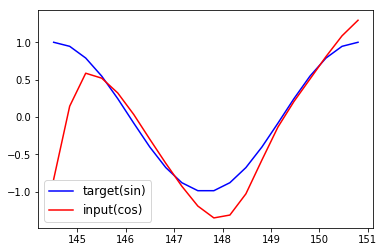

10


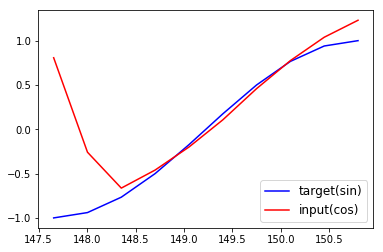

10


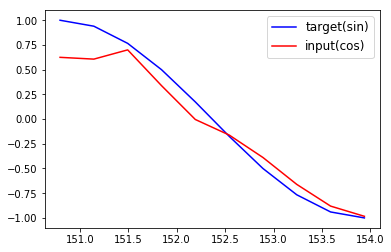

20


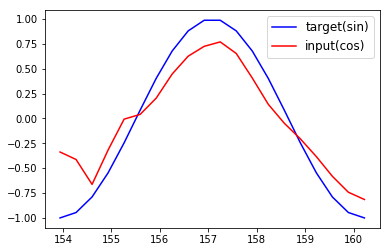

20


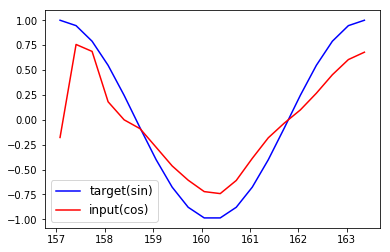

10


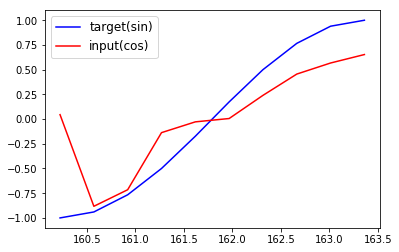

10


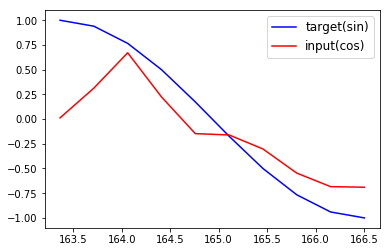

10


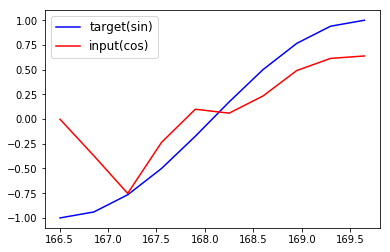

20


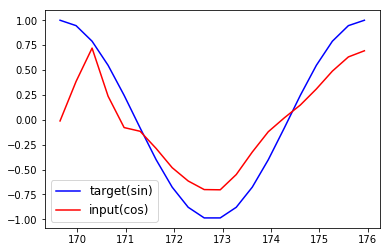

30


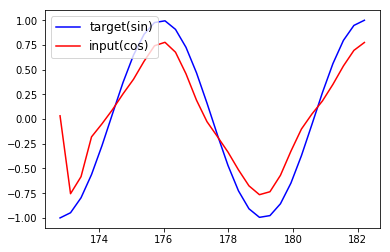

10


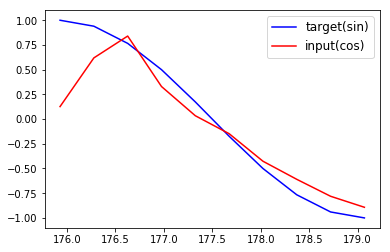

10


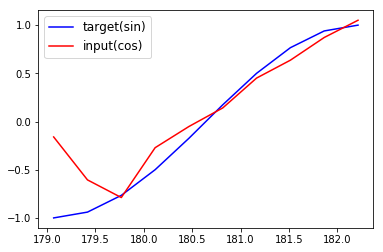

10


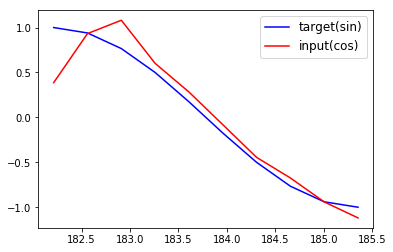

30


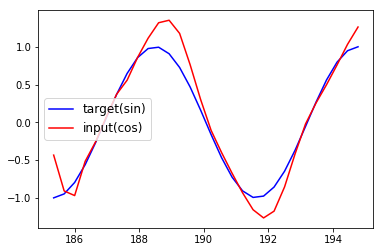

10


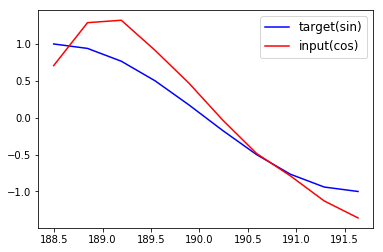

20


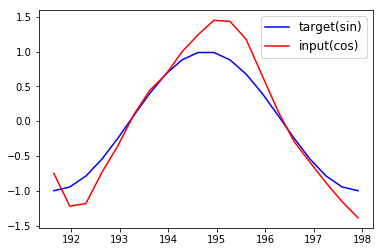

30


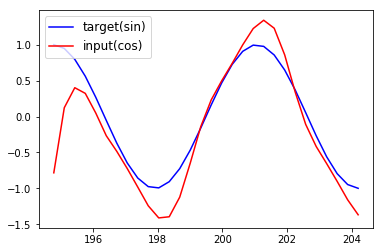

10


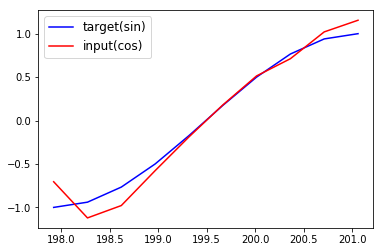

30


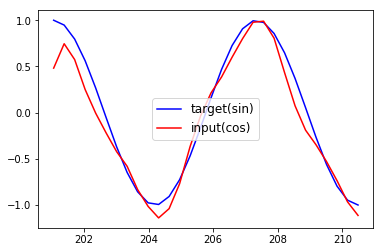

10


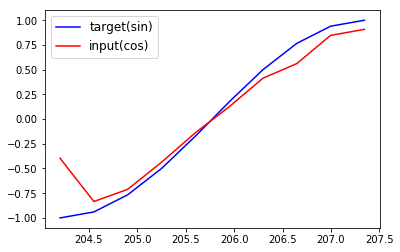

20


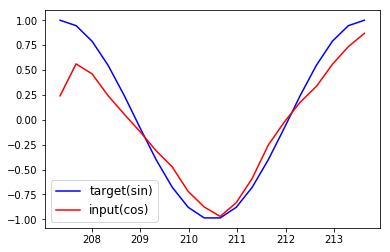

20


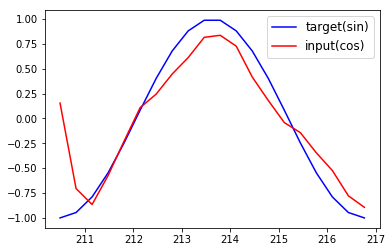

10


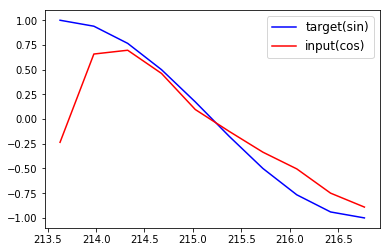

20


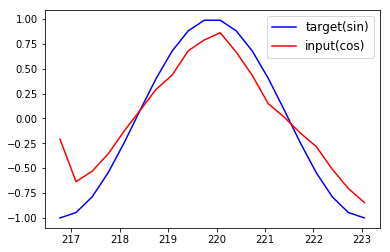

20


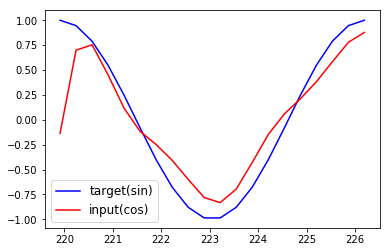

10


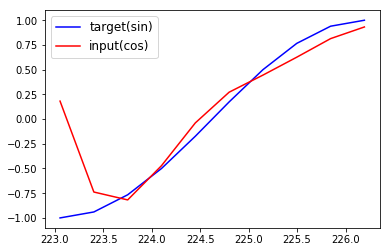

20


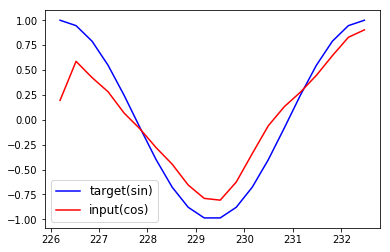

10


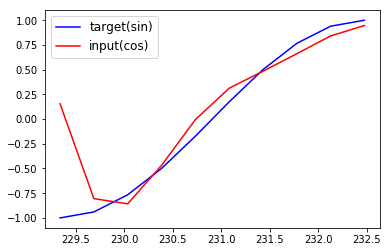

20


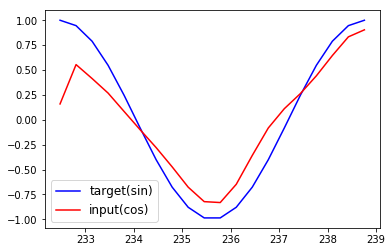

20


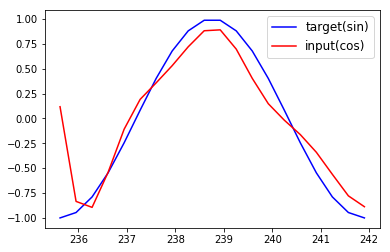

10


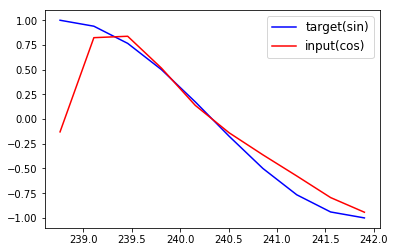

20


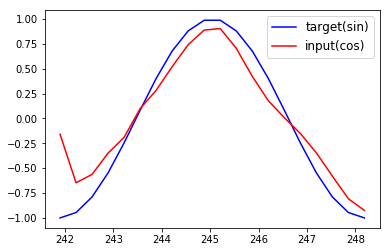

20


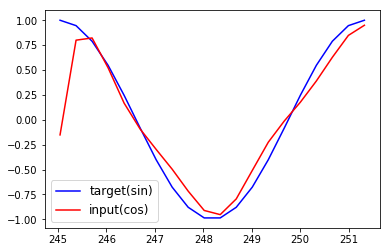

20


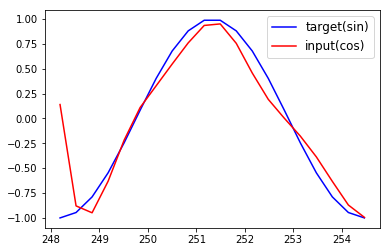

10


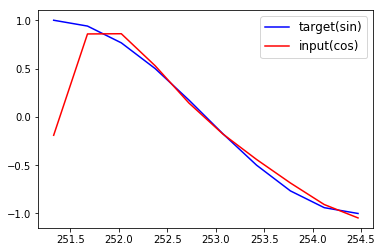

10


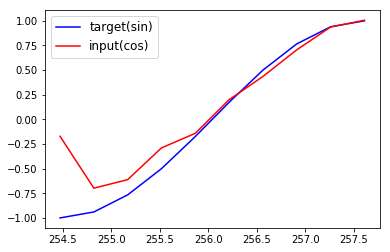

10


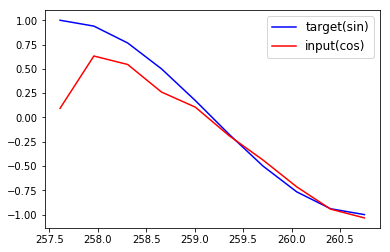

30


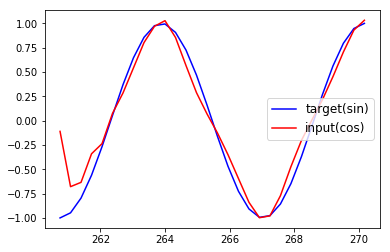

30


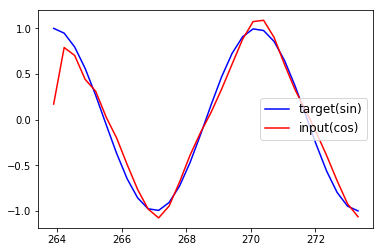

30


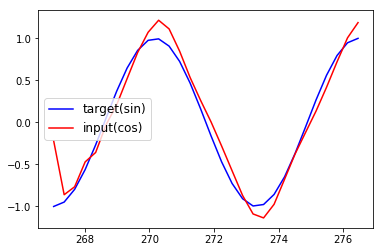

10


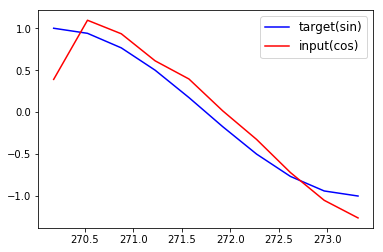

20


KeyboardInterrupt: 

In [16]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=1,
            batch_first=True,
        )
        self.out = nn.Linear(32,1)
        
    def forward(self, x, h_state):  # 因为 hidden state 是连续的, 所以我们要一直传递这一个 state,所以要当成一个参数不断输入和更新
        # x (batch, time_step, input_size),这里的batch为1，time_step为随机的
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入,h_state这里只有一个
                                                # r_out size为 (batch * time_step(10) * hidden_size(32))

        outs = []    
        for time_step in range(r_out.size(1)):    # 对每一个时间点计算 output，r_out.size(1)的大小为time_step的大小，这里为随机的
            outs.append(self.out(r_out[:, time_step, :])) #[:, time_step, :]的dim为batch * output_size,这里是1*32,经过self.out后变为1*1
                                                          #因此，最后的outs的dim是time_step个batch * 结果dim(这里为1)的
        return torch.stack(outs, dim=1), h_state   #stack(dim=1)的作用是让每个batch的时间序列放到一起，则最后的dim变成了
                                                   #batch * time_step_ * 结果的dim(这里为1),这里为1*time_step的size*1,stack具体用法看下面
        
rnn = RNN()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.MSELoss()

h_state = None   # hidden state的初始值，可以设成 None

plt.figure(1, figsize=(12, 5))       #可以在同一个图上一直画下去，但是notebook不支持这个功能
plt.ion()           # continuously plot

for step in range(100):     #这里将曲线按阶段来训练，即每一个pi的时间段训练一次，实际上相当于多个batch按时间排列，
                            # 以查看学习效果按时间的变化程度，但是在rnn的输入x中batch的dim仍为1
    # 本节精华！ 考虑time_step是动态的
    dynamic_steps = np.random.randint(1,4)
    start, end = step*np.pi, (step+dynamic_steps)*np.pi
    step += dynamic_steps       #更新step
    
    steps = np.linspace(start,end,10 * dynamic_steps,dtype=np.float32)
    print(len(steps))
    
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])             #shape (batch, time_step, input_size)，这里为1*10*1
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    
    prediction, h_state = rnn(x, h_state)   # rnn 对于每个 step 的 prediction, 还有最后一个 step 的 h_state

    loss = loss_func(prediction, y)     
    optimizer.zero_grad()               
    loss.backward(retain_graph=True)    
    optimizer.step()                    
    
    # plotting
    plt.plot(steps, y_np.flatten(), 'b-',label='target(sin)')           #这里y_np的dim为10，flatten()没有意义，但是可能其他例子需要
    plt.plot(steps, prediction.data.numpy().flatten(), 'r-',label='input(cos)') #prediction 的dim是1*10*1，是tensor
    plt.legend(loc='best',fontsize='large')
    plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()